# Imports


In [3]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime

# Machine Learning Models
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# System & Warning Control
import os
import warnings
warnings.filterwarnings("ignore")

# Notebook Style
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook")


# Load COVID-19 Datasets

In [4]:
# Base URLs for time series data (JHU GitHub)
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/"
ts_url = base_url + "csse_covid_19_time_series/"

# Time series data files
files = {
    'confirmed': ts_url + "time_series_covid19_confirmed_global.csv",
    'deaths': ts_url + "time_series_covid19_deaths_global.csv",
    'recovered': ts_url + "time_series_covid19_recovered_global.csv"
}

# Load the datasets
def load_covid_data():
    df_confirmed = pd.read_csv(files['confirmed'])
    df_deaths = pd.read_csv(files['deaths'])
    try:
        df_recovered = pd.read_csv(files['recovered'])  # sometimes not updated
    except:
        df_recovered = pd.DataFrame()
    return df_confirmed, df_deaths, df_recovered

df_confirmed, df_deaths, df_recovered = load_covid_data()

# Quick preview
print("Confirmed shape:", df_confirmed.shape)
print("Deaths shape:", df_deaths.shape)
print("Recovered shape:", df_recovered.shape)
df_confirmed.head()


Confirmed shape: (289, 1147)
Deaths shape: (289, 1147)
Recovered shape: (274, 1147)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


# Data Reshaping Function

In [5]:
def preprocess_time_series(df, value_name="value"):
    df_long = df.melt(
        id_vars=["Province/State", "Country/Region", "Lat", "Long"],
        var_name="Date",
        value_name=value_name
    )
    df_long["Date"] = pd.to_datetime(df_long["Date"])
    return df_long

df_confirmed_long = preprocess_time_series(df_confirmed, "Confirmed")
df_deaths_long = preprocess_time_series(df_deaths, "Deaths")
df_recovered_long = preprocess_time_series(df_recovered, "Recovered") if not df_recovered.empty else None


# Merged Datasets

In [6]:
# Merge Confirmed & Deaths
df_merge = pd.merge(df_confirmed_long, df_deaths_long, on=["Country/Region", "Province/State", "Lat", "Long", "Date"])

# Merge Recovered (if exists)
if df_recovered_long is not None:
    df_merge = pd.merge(df_merge, df_recovered_long, on=["Country/Region", "Province/State", "Lat", "Long", "Date"])
else:
    df_merge["Recovered"] = np.nan

# Fill missing Recovered with 0 (optional)
df_merge["Recovered"].fillna(0, inplace=True)

# Preview final dataset
df_merge.head()


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0


# Global Aggregated Trends

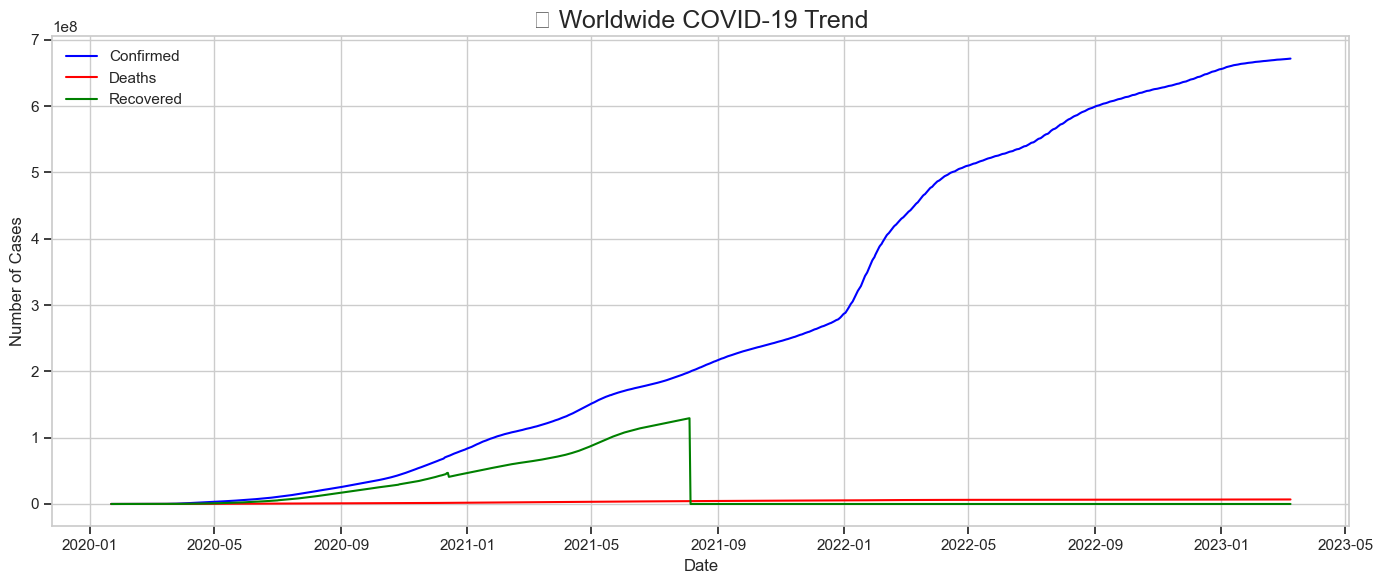

In [7]:
# Aggregate by Date (worldwide)
global_df = df_merge.groupby("Date")[["Confirmed", "Deaths", "Recovered"]].sum().reset_index()

# Plotting global trends
plt.figure(figsize=(14, 6))
plt.plot(global_df["Date"], global_df["Confirmed"], label="Confirmed", color="blue")
plt.plot(global_df["Date"], global_df["Deaths"], label="Deaths", color="red")
plt.plot(global_df["Date"], global_df["Recovered"], label="Recovered", color="green")
plt.title("🌍 Worldwide COVID-19 Trend", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.legend()
plt.tight_layout()
plt.show()



# Daily cases

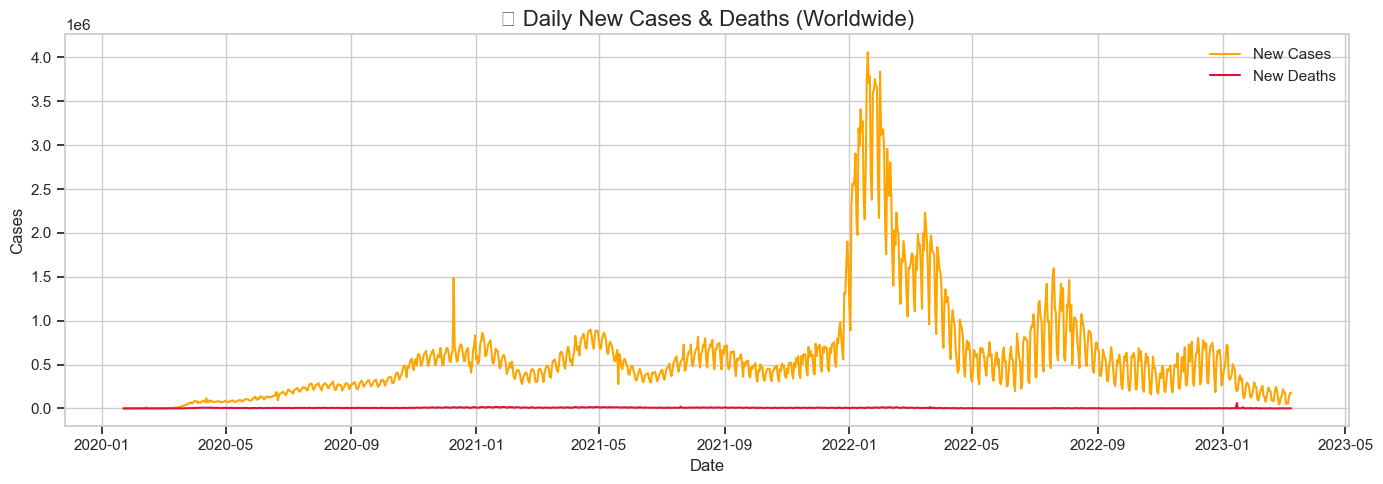

In [8]:
# Daily change
global_df["Daily Confirmed"] = global_df["Confirmed"].diff().fillna(0)
global_df["Daily Deaths"] = global_df["Deaths"].diff().fillna(0)

# Plot daily cases
plt.figure(figsize=(14, 5))
plt.plot(global_df["Date"], global_df["Daily Confirmed"], label="New Cases", color="orange")
plt.plot(global_df["Date"], global_df["Daily Deaths"], label="New Deaths", color="crimson")
plt.title("📊 Daily New Cases & Deaths (Worldwide)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.tight_layout()
plt.show()


# Country-Specific Visualization

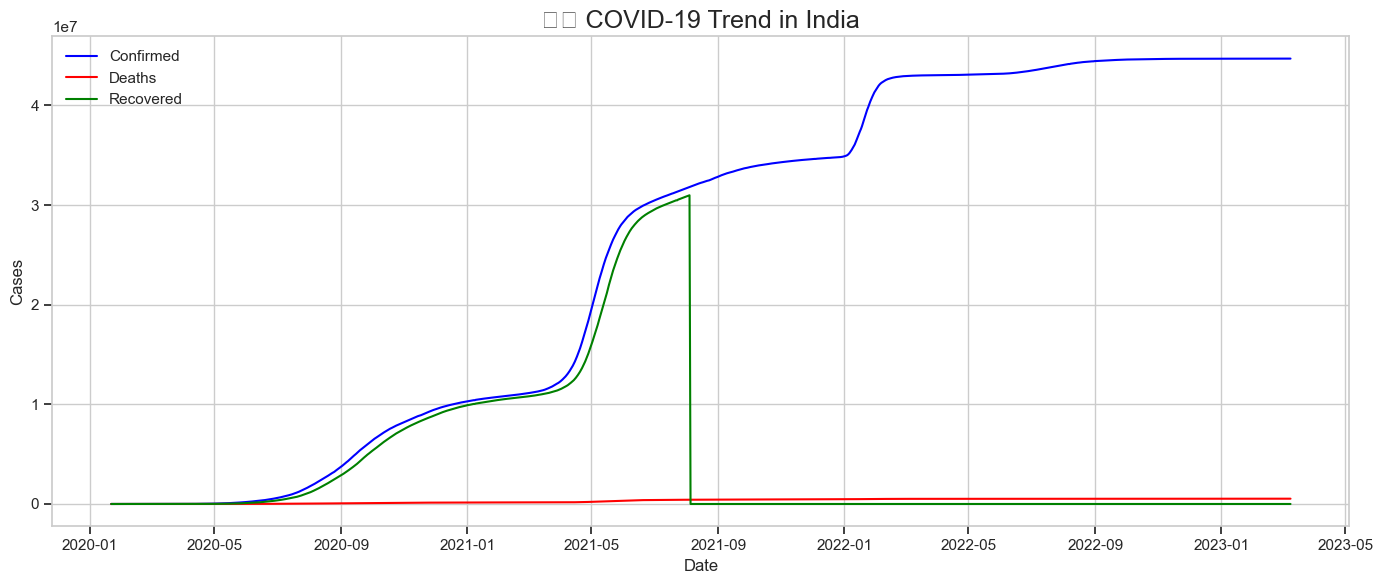

In [9]:
def plot_country_trend(country):
    df_country = df_merge[df_merge["Country/Region"] == country].groupby("Date")[["Confirmed", "Deaths", "Recovered"]].sum().reset_index()

    plt.figure(figsize=(14, 6))
    plt.plot(df_country["Date"], df_country["Confirmed"], label="Confirmed", color="blue")
    plt.plot(df_country["Date"], df_country["Deaths"], label="Deaths", color="red")
    plt.plot(df_country["Date"], df_country["Recovered"], label="Recovered", color="green")
    plt.title(f"🇨🇮 COVID-19 Trend in {country}", fontsize=18)
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Try:
plot_country_trend("India")


# Global Distribution

In [10]:
latest = df_merge[df_merge["Date"] == df_merge["Date"].max()]
global_latest = latest.groupby("Country/Region")[["Confirmed", "Deaths", "Recovered"]].sum().reset_index()
top10 = global_latest.sort_values("Confirmed", ascending=False).head(10)

# Pie Chart for Confirmed Cases
fig = px.pie(top10, values="Confirmed", names="Country/Region", title="🔝 Top 10 Countries by Confirmed Cases")
fig.show()



# Bar Chart for Top Countries

In [11]:
# Bar chart
fig = px.bar(top10, x="Country/Region", y=["Confirmed", "Deaths", "Recovered"],
             title="📊 Top 10 Affected Countries (Latest Data)",
             labels={"value": "Number of Cases", "variable": "Metric"},
             barmode="group")
fig.show()


# Preparing Data

In [12]:
# Days to use for training (latest 100 days)
train_window = 100

# Extract recent data
df_train = global_df[-train_window:].copy()

# Features and labels
df_train["Days"] = np.arange(len(df_train))  # X
X = df_train[["Days"]]
y = df_train["Confirmed"]


# Defining Models

In [13]:
# Polynomial Regression (degree 3)
poly_model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())

# Support Vector Machine Regression
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=1)

# Bayesian Ridge Regression
bayesian_model = BayesianRidge()


# Training Models

In [14]:
poly_model.fit(X, y)
svm_model.fit(X, y)
bayesian_model.fit(X, y)


BayesianRidge()

# Predictions

In [15]:
future_days = 30
total_days = train_window + future_days

X_future = pd.DataFrame({"Days": np.arange(total_days)})
df_future = pd.DataFrame({"Date": pd.date_range(start=global_df["Date"].iloc[-train_window], periods=total_days)})

# Add predictions
df_future["Polynomial"] = poly_model.predict(X_future)
df_future["SVM"] = svm_model.predict(X_future)
df_future["Bayesian"] = bayesian_model.predict(X_future)

# Merge actual data for comparison
df_future["Actual"] = np.append(y.values, [np.nan]*future_days)


# Plotting the Predictions

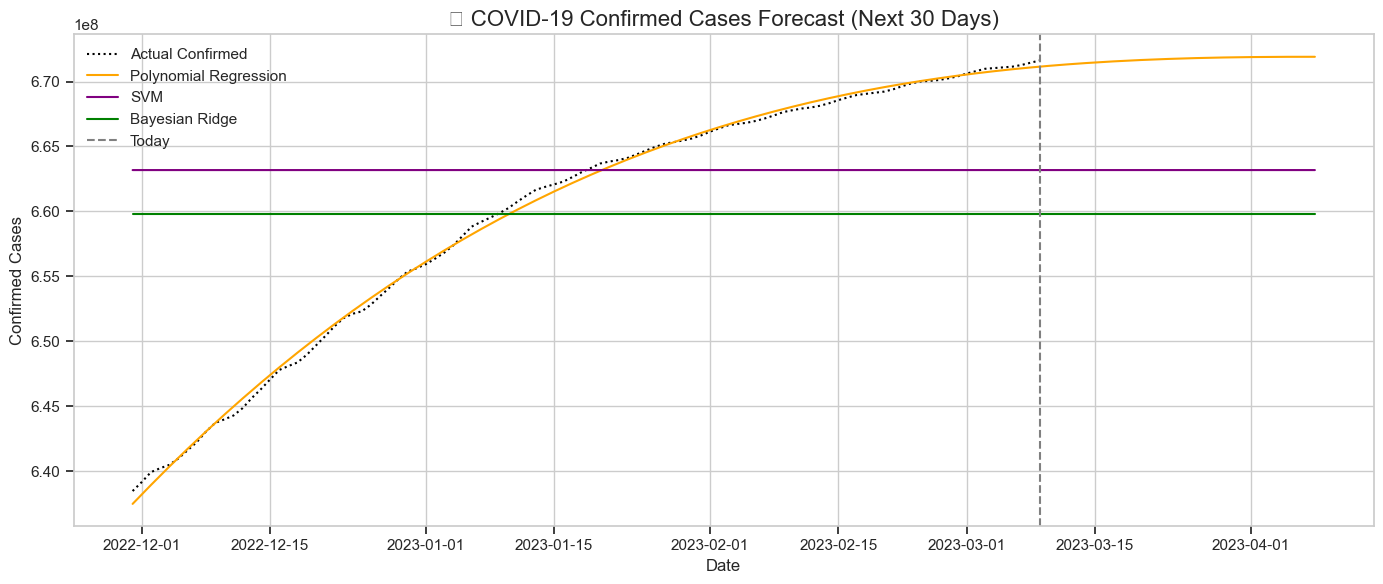

In [16]:
plt.figure(figsize=(14, 6))

plt.plot(df_future["Date"], df_future["Actual"], label="Actual Confirmed", color="black", linestyle='dotted')
plt.plot(df_future["Date"], df_future["Polynomial"], label="Polynomial Regression", color="orange")
plt.plot(df_future["Date"], df_future["SVM"], label="SVM", color="purple")
plt.plot(df_future["Date"], df_future["Bayesian"], label="Bayesian Ridge", color="green")

plt.axvline(global_df["Date"].iloc[-1], color="gray", linestyle="--", label="Today")

plt.title("📈 COVID-19 Confirmed Cases Forecast (Next 30 Days)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Compare Performance on Training Data

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

print("📊 Model Performance on Training Data:")
for name, model in zip(["Polynomial", "SVM", "Bayesian"], [poly_model, svm_model, bayesian_model]):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"{name}: R² = {r2:.4f}, MSE = {mse:.2f}")


📊 Model Performance on Training Data:
Polynomial: R² = 0.9984, MSE = 157961550144.82
SVM: R² = -0.1166, MSE = 107703375600204.23
Bayesian: R² = 0.0000, MSE = 96455086116291.22


# Conclusion:

In [18]:
This project presents a comprehensive analysis and short-term forecasting of the COVID-19 pandemic using globally recognized time series data from Johns Hopkins University.

Key Insights:
    
- Analyzed global and country-wise trends of confirmed, recovered, and death cases.
- Visualized both cumulative and daily trends using Matplotlib and Plotly.
- Compared country-level impact through interactive pie and bar charts.
- Developed and evaluated multiple regression models — Polynomial Regression, Support Vector Regression (SVR), and Bayesian Ridge — to forecast future confirmed cases.
- Generated 30-day forecasts and compared models using R² score and Mean Squared Error (MSE).

Skills Demonstrated:
    
- Time Series Data Wrangling and Preprocessing
- Exploratory Data Analysis (EDA) and Trend Visualization
- Supervised Learning for Forecasting using Scikit-learn
- Interactive Visualization Techniques with Plotly

Future Enhancements:
    
- Incorporate vaccination and population data for deeper epidemiological context
- Use advanced time series models like **LSTM** or **Prophet** for more robust forecasting
- Build an interactive **Streamlit dashboard** for real-time country-wise tracking and predictions


SyntaxError: invalid character '—' (U+2014) (1206031714.py, line 8)